## This notebook gives an overview of how to use Lichess's game data on 960 games to evaluate the quality of 960 starting positions. We start by giving a list of locations of PGNs to load

In [1]:
PGN_LOCS = [
    "/opt/nfs/lichess_dbs/chess_960/lichess_db_chess960_rated_2022-07.pgn",
    "/opt/nfs/lichess_dbs/chess_960/lichess_db_chess960_rated_2022-06.pgn",
    "/opt/nfs/lichess_dbs/chess_960/lichess_db_chess960_rated_2022-05.pgn",
    "/opt/nfs/lichess_dbs/chess_960/lichess_db_chess960_rated_2022-04.pgn",
]

## With this list we use python-chess to load these games into objects as we are only interested in the data in the headers to extract. We use a generator to limit RAM usage as we can discard our chess game objects after we extract out relevant data

In [2]:
import io
import itertools

from catboost import CatBoostClassifier, Pool
import chess
import chess.pgn
import cloudpickle
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score


from tqdm.notebook import tqdm

def parse_game_lines(data):
    games = []
    current_game_data = []
    new_line_count = 0
    for line in data:
        if line == '\n':
            new_line_count += 1
        if new_line_count == 2:
            games.append("".join(current_game_data))
            new_line_count = 0
            current_game_data = []
        else:
            current_game_data.append(line)
    if current_game_data:
        games.append("".join(current_game_data))
    return games


def convert_pgns_to_games(pgns):
    #Use a generator as we want to extract data from these game objects and don't need them all at once
    return ( chess.pgn.read_game(io.StringIO(pgn)) for pgn in pgns )

In [3]:
game_gens = []
num_games = []
for pgn_loc in tqdm(PGN_LOCS):
    with open(pgn_loc) as f:
        pgns = parse_game_lines(f.readlines())
        num_games.append(len(pgns))
        games = convert_pgns_to_games(pgns)

    game_gens.append(games)

In [4]:
def extract_game_data(game):
    headers = game.headers
    return {
        'black_elo': headers['BlackElo'],
        'white_elo': headers['WhiteElo'],
        'position': headers['FEN'].split("/")[0],
        'time_control': headers['TimeControl'],
        'result': headers['Result']
    }

## We are interested in outcomes as our proxy for game quality and we pull ELO, ELO differences, and the time control as well as the position for our analysis

In [5]:
games_data = []
for i, games in enumerate(game_gens):
    gd = [ extract_game_data(game) for game in tqdm(games, total=num_games[i]) ]
    games_data += gd

In [8]:
import pandas as pd

games_df = pd.DataFrame(games_data)
games_df.head()

black_elo white_elo  position time_control result
0      1870      1602  nrqbbnkr         60+0    0-1
1      1674      1500  qbrknrbn        300+0    0-1
2      1320      1275  rqnkrnbb        300+0    1-0
3      1216      1091  rnbqkbnr        300+0    1-0
4      1710      1555  rqbbknrn        180+2    0-1

In [9]:
def try_elo_diff(x):
    try:
        return int(x['white_elo'])-int(x['black_elo'])
    except Exception:
        return None

    
def assign_time_class(x):
    seconds = int(x.split("+")[0])
    if seconds < 180:
        return 'bullet'
    if seconds < 8*60:
        return 'blitz'
    if seconds < 30*60:
        return 'rapid'
    else:
        return 'classical'

    
games_df['white_elo_diff'] = games_df.apply(lambda x: try_elo_diff(x), axis=1)
games_df['time_class'] = games_df['time_control'].apply(assign_time_class)
games_df.head()

black_elo white_elo  position time_control result  white_elo_diff time_class
0      1870      1602  nrqbbnkr         60+0    0-1            -268     bullet
1      1674      1500  qbrknrbn        300+0    0-1            -174      blitz
2      1320      1275  rqnkrnbb        300+0    1-0             -45      blitz
3      1216      1091  rnbqkbnr        300+0    1-0            -125      blitz
4      1710      1555  rqbbknrn        180+2    0-1            -155      blitz

In [10]:
games_df.to_csv('lichess_960_result_data.csv', index=False)

## With our extracted data, we can now look at some summary metrics and look at some distributions of the data

In [11]:
games_df.groupby(['time_class']).size()

time_class
blitz        606007
bullet       404968
classical      2720
rapid         44165
dtype: int64

In [12]:
import seaborn as sns

sns.distplot(games_df['white_elo_diff'])

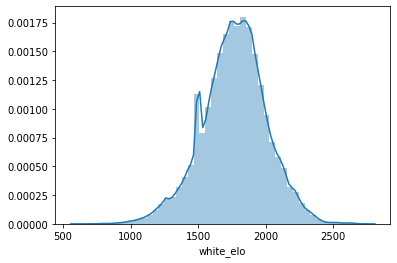

In [13]:
sns.distplot(games_df['white_elo'])

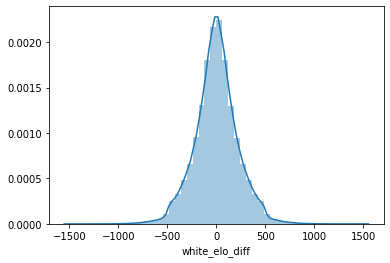

In [85]:
sns.distplot(games_df['white_elo_diff'])

In [14]:
games_df.groupby(['position']).size().sort_values(ascending=False)

position
nbqrkrbn    1217
bnnrqkrb    1217
rnbkqnrb    1215
nbbnrkrq    1209
bnrbkrnq    1205
            ... 
rknbbqnr    1003
nrnkqbbr    1000
rnbqkbnr     992
nqbbrknr     990
rbqnbnkr     980
Length: 960, dtype: int64

## Classical doesn't have enough games to be relevant, so we remove those and make sure we only include games that have results

In [15]:
def filter_data(df):
    valid_results = df[df['result'].isin(['0-1','1-0','1/2-1/2'])]
    return valid_results[valid_results['time_class'].isin(['bullet', 'blitz', 'rapid'])]

filtered_data = filter_data(games_df)
filtered_data.head()

black_elo white_elo  position time_control result  white_elo_diff time_class
0      1870      1602  nrqbbnkr         60+0    0-1            -268     bullet
1      1674      1500  qbrknrbn        300+0    0-1            -174      blitz
2      1320      1275  rqnkrnbb        300+0    1-0             -45      blitz
3      1216      1091  rnbqkbnr        300+0    1-0            -125      blitz
4      1710      1555  rqbbknrn        180+2    0-1            -155      blitz

In [227]:
filtered_data['white_rating_bin'] = filtered_data['white_elo'].apply(lambda x: round(int(x)/100))
filtered_data['dummy']=1
filtered_data.head()

black_elo white_elo  position time_control result  white_elo_diff  \
0      1870      1602  nrqbbnkr         60+0    0-1            -268   
1      1674      1500  qbrknrbn        300+0    0-1            -174   
2      1320      1275  rqnkrnbb        300+0    1-0             -45   
3      1216      1091  rnbqkbnr        300+0    1-0            -125   
4      1710      1555  rqbbknrn        180+2    0-1            -155   

  time_class  white_rating_bin  dummy  
0     bullet                16      1  
1      blitz                15      1  
2      blitz                13      1  
3      blitz                11      1  
4      blitz                16      1

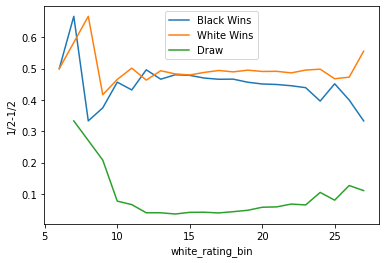

In [237]:
close_matches = filtered_data[abs(filtered_data['white_elo_diff'])<50]
rating_bin_grouped = close_matches.groupby(['white_rating_bin', 'result']).size().reset_index()
rating_bin_grouped.columns = ['white_rating_bin', 'result', 'games']
rating_bin_grouped['result_percentage'] = rating_bin_grouped['games'] / rating_bin_grouped.groupby('white_rating_bin')['games'].transform('sum')
rating_bin_pivoted = pd.pivot_table(rating_bin_grouped, values='result_percentage', index=['white_rating_bin'], columns=['result']).reset_index()
sns.lineplot(data=rating_bin_pivoted, x='white_rating_bin', y='0-1', label='Black Wins')
sns.lineplot(data=rating_bin_pivoted, x='white_rating_bin', y='1-0', label='White Wins')
sns.lineplot(data=rating_bin_pivoted, x='white_rating_bin', y='1/2-1/2', label='Draw')

In [16]:
result_df = filtered_data.groupby(['position', 'result']).size().reset_index()
result_df.columns = ['position', 'result', 'games']


result_df['result_percentage'] = result_df['games'] / result_df.groupby('position')['games'].transform('sum')

result_df.head()

position   result  games  result_percentage
0  bbnnqrkr      0-1    524           0.461268
1  bbnnqrkr      1-0    564           0.496479
2  bbnnqrkr  1/2-1/2     48           0.042254
3  bbnnrkqr      0-1    578           0.494017
4  bbnnrkqr      1-0    538           0.459829

## We can pivot from our previous form to get a dataframe that gives percentages of results for each position

In [17]:
results_pivot = pd.pivot_table(result_df, values='result_percentage', index=['position'], columns=['result']).reset_index()
results_pivot.head()

result  position       0-1       1-0   1/2-1/2
0       bbnnqrkr  0.461268  0.496479  0.042254
1       bbnnrkqr  0.494017  0.459829  0.046154
2       bbnnrkrq  0.466541  0.507069  0.026390
3       bbnnrqkr  0.474622  0.490650  0.034728
4       bbnqnrkr  0.447415  0.516934  0.035651

## We need to construct a metric to convert the percentages of the three results. I chose to use the absolute difference of win rates with the draw rate to quanitfy how 'fun' a game was

In [18]:
def calculate_fun_index(x):
    return (1-abs(x['1-0']-x['0-1']))-(x['1/2-1/2'])


def construct_fen(position):
    return f'{position}/pppppppp/8/8/8/8/PPPPPPPP/{position.upper()}'
    

results_pivot['fun_index'] = results_pivot.apply(calculate_fun_index, axis=1)
results_pivot['fen'] = results_pivot['position'].apply(construct_fen)
results_pivot.head()

result  position       0-1       1-0   1/2-1/2  fun_index  \
0       bbnnqrkr  0.461268  0.496479  0.042254   0.922535   
1       bbnnrkqr  0.494017  0.459829  0.046154   0.919658   
2       bbnnrkrq  0.466541  0.507069  0.026390   0.933082   
3       bbnnrqkr  0.474622  0.490650  0.034728   0.949243   
4       bbnqnrkr  0.447415  0.516934  0.035651   0.894831   

result                                          fen  
0       bbnnqrkr/pppppppp/8/8/8/8/PPPPPPPP/BBNNQRKR  
1       bbnnrkqr/pppppppp/8/8/8/8/PPPPPPPP/BBNNRKQR  
2       bbnnrkrq/pppppppp/8/8/8/8/PPPPPPPP/BBNNRKRQ  
3       bbnnrqkr/pppppppp/8/8/8/8/PPPPPPPP/BBNNRQKR  
4       bbnqnrkr/pppppppp/8/8/8/8/PPPPPPPP/BBNQNRKR

## We can now rank positions on this 'fun' index 

In [19]:
results_pivot.sort_values(['fun_index']).head(10)

result  position       0-1       1-0   1/2-1/2  fun_index  \
709     rkbnqrnb  0.424746  0.530933  0.044321   0.849492   
29      bbqrnnkr  0.427382  0.530990  0.041628   0.854764   
309     nnbrkrqb  0.427644  0.519481  0.052876   0.855288   
727     rknbbnrq  0.433180  0.518894  0.047926   0.866359   
33      bbrknqrn  0.433790  0.521461  0.044749   0.867580   
310     nnbrqbkr  0.434701  0.515858  0.049440   0.869403   
841     rnkbnrbq  0.435161  0.523934  0.040905   0.870322   
291     nbrnkqbr  0.435528  0.533814  0.030658   0.871055   
797     rkrqnnbb  0.436416  0.531792  0.031792   0.872832   
178     brkqrbnn  0.436866  0.516129  0.047005   0.873733   

result                                          fen  
709     rkbnqrnb/pppppppp/8/8/8/8/PPPPPPPP/RKBNQRNB  
29      bbqrnnkr/pppppppp/8/8/8/8/PPPPPPPP/BBQRNNKR  
309     nnbrkrqb/pppppppp/8/8/8/8/PPPPPPPP/NNBRKRQB  
727     rknbbnrq/pppppppp/8/8/8/8/PPPPPPPP/RKNBBNRQ  
33      bbrknqrn/pppppppp/8/8/8/8/PPPPPPPP/BBRKNQRN  
310     nnbrqbkr/pppppppp/8/8/8/8/PPPPPPPP/NNBRQBKR  
841     rnkbnrbq/pppppppp/8/8/8/8/PPPPPPPP/RNKBNRBQ  
291     nbrnkqbr/pppppppp/8/8/8/8/PPPPPPPP/NBRNKQBR  
797     rkrqnnbb/pppppppp/8/8/8/8/PPPPPPPP/RKRQNNBB  
178     brkqrbnn/pppppppp/8/8/8/8/PPPPPPPP/BRKQRBNN

In [20]:
results_pivot.sort_values(['fun_index']).tail(10)

result  position       0-1       1-0   1/2-1/2  fun_index  \
789     rkrnbqnb  0.488351  0.484767  0.026882   0.969534   
505     qbrnbkrn  0.484821  0.484821  0.030359   0.969641   
671     rbnnqkbr  0.485793  0.484876  0.029331   0.969753   
369     nqrnbkrb  0.485062  0.485062  0.029877   0.970123   
717     rkbqnrnb  0.485764  0.485764  0.028473   0.971527   
767     rkqbrnbn  0.487873  0.486007  0.026119   0.972015   
112     bnrnqbkr  0.486038  0.486038  0.027923   0.972077   
276     nbrkbnqr  0.488932  0.486044  0.025024   0.972089   
508     qbrnkrbn  0.486059  0.489777  0.024164   0.972119   
812     rnbknqrb  0.487085  0.487085  0.025830   0.974170   

result                                          fen  
789     rkrnbqnb/pppppppp/8/8/8/8/PPPPPPPP/RKRNBQNB  
505     qbrnbkrn/pppppppp/8/8/8/8/PPPPPPPP/QBRNBKRN  
671     rbnnqkbr/pppppppp/8/8/8/8/PPPPPPPP/RBNNQKBR  
369     nqrnbkrb/pppppppp/8/8/8/8/PPPPPPPP/NQRNBKRB  
717     rkbqnrnb/pppppppp/8/8/8/8/PPPPPPPP/RKBQNRNB  
767     rkqbrnbn/pppppppp/8/8/8/8/PPPPPPPP/RKQBRNBN  
112     bnrnqbkr/pppppppp/8/8/8/8/PPPPPPPP/BNRNQBKR  
276     nbrkbnqr/pppppppp/8/8/8/8/PPPPPPPP/NBRKBNQR  
508     qbrnkrbn/pppppppp/8/8/8/8/PPPPPPPP/QBRNKRBN  
812     rnbknqrb/pppppppp/8/8/8/8/PPPPPPPP/RNBKNQRB

In [129]:
results_pivot.sort_values('0-1', ascending=False).head()

result  position       0-1       1-0   1/2-1/2  fun_index  \
408     nrkbbnqr  0.517150  0.444151  0.038698   0.888303   
877     rnnkbbrq  0.511765  0.456303  0.031933   0.912605   
14      bbnrnkqr  0.506494  0.459184  0.034323   0.918367   
249     nbbrknrq  0.505445  0.460980  0.033575   0.921960   
615     rbbnkqrn  0.504682  0.447566  0.047753   0.895131   

result                                          fen  
408     nrkbbnqr/pppppppp/8/8/8/8/PPPPPPPP/NRKBBNQR  
877     rnnkbbrq/pppppppp/8/8/8/8/PPPPPPPP/RNNKBBRQ  
14      bbnrnkqr/pppppppp/8/8/8/8/PPPPPPPP/BBNRNKQR  
249     nbbrknrq/pppppppp/8/8/8/8/PPPPPPPP/NBBRKNRQ  
615     rbbnkqrn/pppppppp/8/8/8/8/PPPPPPPP/RBBNKQRN

In [130]:
results_pivot.sort_values('1-0', ascending=False).head()

result  position       0-1       1-0   1/2-1/2  fun_index  \
291     nbrnkqbr  0.435528  0.533814  0.030658   0.871055   
797     rkrqnnbb  0.436416  0.531792  0.031792   0.872832   
29      bbqrnnkr  0.427382  0.530990  0.041628   0.854764   
709     rkbnqrnb  0.424746  0.530933  0.044321   0.849492   
52      bbrnqkrn  0.439355  0.525869  0.034775   0.878711   

result                                          fen  
291     nbrnkqbr/pppppppp/8/8/8/8/PPPPPPPP/NBRNKQBR  
797     rkrqnnbb/pppppppp/8/8/8/8/PPPPPPPP/RKRQNNBB  
29      bbqrnnkr/pppppppp/8/8/8/8/PPPPPPPP/BBQRNNKR  
709     rkbnqrnb/pppppppp/8/8/8/8/PPPPPPPP/RKBNQRNB  
52      bbrnqkrn/pppppppp/8/8/8/8/PPPPPPPP/BBRNQKRN

In [131]:
results_pivot.sort_values('1/2-1/2', ascending=False).head()

result  position       0-1       1-0   1/2-1/2  fun_index  \
100     bnrkqbnr  0.485041  0.456936  0.058024   0.913871   
128     bqnrknrb  0.453988  0.488168  0.057844   0.907975   
652     rbkrnqbn  0.454466  0.487741  0.057793   0.908932   
203     brnkqbrn  0.449814  0.492565  0.057621   0.899628   
83      bnqrnkrb  0.465181  0.478180  0.056639   0.930362   

result                                          fen  
100     bnrkqbnr/pppppppp/8/8/8/8/PPPPPPPP/BNRKQBNR  
128     bqnrknrb/pppppppp/8/8/8/8/PPPPPPPP/BQNRKNRB  
652     rbkrnqbn/pppppppp/8/8/8/8/PPPPPPPP/RBKRNQBN  
203     brnkqbrn/pppppppp/8/8/8/8/PPPPPPPP/BRNKQBRN  
83      bnqrnkrb/pppppppp/8/8/8/8/PPPPPPPP/BNQRNKRB

In [132]:
results_pivot.sort_values('1/2-1/2').head()

result  position       0-1       1-0   1/2-1/2  fun_index  \
255     nbbrnkrq  0.477055  0.501912  0.021033   0.954111   
784     rkrbnqbn  0.477124  0.500467  0.022409   0.954248   
661     rbnknrbq  0.467684  0.509874  0.022442   0.935368   
506     qbrnbnkr  0.473638  0.503515  0.022847   0.947276   
483     qbbnrnkr  0.467967  0.508821  0.023213   0.935933   

result                                          fen  
255     nbbrnkrq/pppppppp/8/8/8/8/PPPPPPPP/NBBRNKRQ  
784     rkrbnqbn/pppppppp/8/8/8/8/PPPPPPPP/RKRBNQBN  
661     rbnknrbq/pppppppp/8/8/8/8/PPPPPPPP/RBNKNRBQ  
506     qbrnbnkr/pppppppp/8/8/8/8/PPPPPPPP/QBRNBNKR  
483     qbbnrnkr/pppppppp/8/8/8/8/PPPPPPPP/QBBNRNKR

## I then export this data for future use

In [21]:
results_pivot.to_csv('fun_index_by_position_lichess_user_data_apr2022_july2022.csv', index=False)

## We can use python-chess's board to SVG feature to see what these least fun and most fun positions look like

The most fun position is:


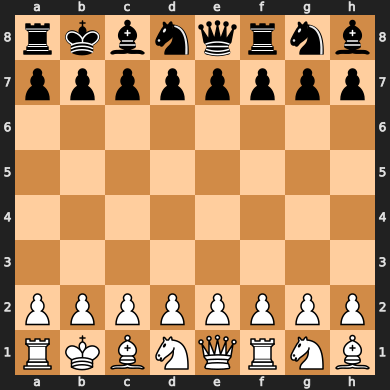

In [22]:
import chess


def print_fen(fen):
    return chess.Board(fen)


print("The least fun position is:")
print_fen(results_pivot.sort_values(['fun_index']).head(10)['fen'].values[0])

The most fun position is:


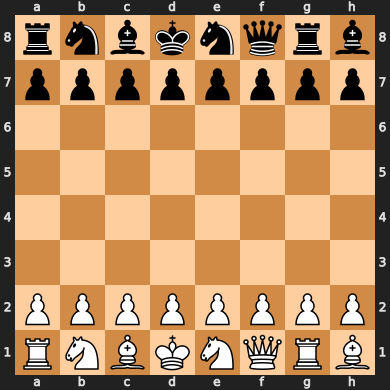

In [23]:
print("The most fun position is:")
print_fen(results_pivot.sort_values(['fun_index']).tail(10)['fen'].values[-1])

## What if we want to go further though? It would be nice if we could have some type of function that takes in our game parameters and estimates game results. This simplifies into a multi class classification problem and as such, we'll use catboost to make simple use of our multiple categories

In [144]:
model_data = filtered_data.loc[:, ['white_elo', 'white_elo_diff', 'position', 'time_class', 'result']]
model_data['white_elo'] = model_data['white_elo'].astype(float)

model_data.head()

white_elo  white_elo_diff  position time_class result
0     1602.0            -268  nrqbbnkr     bullet    0-1
1     1500.0            -174  qbrknrbn      blitz    0-1
2     1275.0             -45  rqnkrnbb      blitz    1-0
3     1091.0            -125  rnbqkbnr      blitz    1-0
4     1555.0            -155  rqbbknrn      blitz    0-1

## We do a bit of preprocessing to separate our continuous and categorical features and do some min-max scaling 

In [145]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(scaler, df, fit=True):
    X_scalar = df.loc[:, ['white_elo', 'white_elo_diff']].values
    X_cats = df.loc[:, ['position', 'time_class']].values
    Y_cats = df['result'].values
    
    if fit:
        scaler.fit(X_scalar)
    X_scalar = scaler.transform(X_scalar)
    X = np.concatenate([X_scalar, X_cats], axis=1)
    return scaler, X, Y_cats 

scaler = MinMaxScaler()
scaler, X, Y = preprocess_data(scaler, model_data)
X

array([[0.46303142329020336, 0.4114342366159947, 'nrqbbnkr', 'bullet'],
       [0.41589648798521256, 0.4424983476536682, 'qbrknrbn', 'blitz'],
       [0.3119223659889094, 0.4851288830138797, 'rqnkrnbb', 'blitz'],
       ...,
       [0.48659889094269865, 0.33674818241903504, 'rkrbnqbn', 'bullet'],
       [0.7823475046210722, 0.5280898876404494, 'nrnbbkrq', 'bullet'],
       [0.5383548983364139, 0.5082617316589557, 'nqnrkrbb', 'blitz']],
      dtype=object)

## We construct a train, eval, and test set from this data

In [150]:
X_train, X_eval, X_test = X[:-20000], X[-20000:-10000], X[-10000:]
Y_train, Y_eval, Y_test = Y[:-20000], Y[-20000:-10000], Y[-10000:]

## We then run it through our classification model

In [153]:
from catboost import CatBoostClassifier, Pool, cv

cat_features = [2, 3]


train_dataset = Pool(data=X_train,
                     label=Y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_eval,
                     label=Y_eval,
                     cat_features=cat_features)

test_dataset = Pool(data=X_test,
                    label=Y_test,
                    cat_features=cat_features)

params = {"iterations": 6000,
          "depth": 6,
          "loss_function": "MultiClass",
          "learning_rate": .01,
          "train_dir": "multiclass"
          }

model = CatBoostClassifier(**params)

model.fit(train_dataset, eval_set=eval_dataset, use_best_model=True, verbose_eval=100, early_stopping_rounds=50)
predictions = model.predict(test_dataset)
preds_proba = model.predict_proba(test_dataset)

0:	learn: 1.0921689	test: 1.0922913	best: 1.0922913 (0)	total: 998ms	remaining: 1h 39m 46s
100:	learn: 0.8040627	test: 0.8080297	best: 0.8080297 (100)	total: 1m 14s	remaining: 1h 12m 30s
200:	learn: 0.7439889	test: 0.7480958	best: 0.7480958 (200)	total: 2m 23s	remaining: 1h 9m 1s
300:	learn: 0.7304458	test: 0.7343291	best: 0.7343291 (300)	total: 3m 29s	remaining: 1h 6m 8s
400:	learn: 0.7273317	test: 0.7311121	best: 0.7311121 (400)	total: 4m 33s	remaining: 1h 3m 35s
500:	learn: 0.7264381	test: 0.7302032	best: 0.7302032 (500)	total: 5m 34s	remaining: 1h 1m 10s
600:	learn: 0.7260593	test: 0.7298358	best: 0.7298358 (600)	total: 6m 31s	remaining: 58m 36s
700:	learn: 0.7258406	test: 0.7296426	best: 0.7296426 (700)	total: 7m 27s	remaining: 56m 23s
800:	learn: 0.7256988	test: 0.7295418	best: 0.7295418 (800)	total: 8m 23s	remaining: 54m 27s
900:	learn: 0.7255889	test: 0.7294618	best: 0.7294613 (899)	total: 9m 36s	remaining: 54m 23s
1000:	learn: 0.7255025	test: 0.7294010	best: 0.7294010 (999)	to

## A confusion matrix is helpful to see what our model predicts

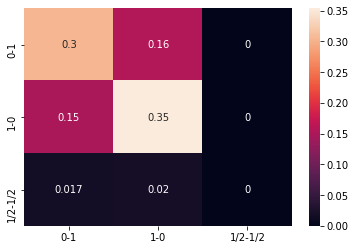

In [154]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


ax= plt.subplot()

cat_descriptions = model_data['result'].unique()

sns.heatmap(confusion_matrix(Y_test, predictions)/len(Y_test), annot=True, ax=ax)
ax.xaxis.set_ticklabels(cat_descriptions)
ax.yaxis.set_ticklabels(cat_descriptions);

## We also use an rocauc score to make sure our model is doing sensible things out of sample

In [155]:
from sklearn.metrics import roc_auc_score

weighted_roc_auc_ovo = roc_auc_score(
    Y_test, preds_proba, multi_class="ovo", average="weighted"
)

weighted_roc_auc_ovo

0.674159186533904

## Finally, we look at logloss which seems reasonable as well

In [156]:
from sklearn.metrics import log_loss

log_loss(Y_test,preds_proba)

0.7326588398998299

## To get an idea of the results of a starting position from different ELOs, ELO differences, and time classes, we compute predictions from our model for each of our variations of interest. We look at ratings by 500 starting at 1000 (what I call low ELO) and end at 2500 (what I call high ELO). We look at ELO differences by 25 between -100 and 100 and look at all of our three time controls

In [157]:
import itertools

ratings = [1000, 1500, 2000, 2500]
positions = filtered_data['position'].unique()
differences = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
time_classes = ['bullet', 'blitz', 'rapid']
result = ['N/A']

def construct_oos_prediction_df(ratings, positions, differences, time_classes, result):
    return pd.DataFrame(list(itertools.product(*[ratings, positions, differences, time_classes, result])))

oos_predictions_df = construct_oos_prediction_df(ratings, positions, differences, time_classes, result)
oos_predictions_df.columns = ['white_elo', 'position', 'white_elo_diff', 'time_class', 'result']
oos_predictions_df.head()

white_elo  position  white_elo_diff time_class result
0       1000  nrqbbnkr            -100     bullet    N/A
1       1000  nrqbbnkr            -100      blitz    N/A
2       1000  nrqbbnkr            -100      rapid    N/A
3       1000  nrqbbnkr             -75     bullet    N/A
4       1000  nrqbbnkr             -75      blitz    N/A

In [158]:
scaler, X_oos, Y_oos = preprocess_data(scaler, oos_predictions_df)

oos_dataset = Pool(data=X_oos,
                    label=Y_oos,
                    cat_features=cat_features)

preds_proba_oos = model.predict_proba(oos_dataset)

In [159]:
preds_oos_df = pd.DataFrame(preds_proba_oos)
preds_oos_df.columns = cat_descriptions
preds_oos_df.head()

0-1       1-0   1/2-1/2
0  0.910289  0.077834  0.011877
1  0.898833  0.083521  0.017645
2  0.847372  0.117175  0.035454
3  0.910289  0.077834  0.011877
4  0.898833  0.083521  0.017645

## We bring our out of sample together with our predictions to get an output dataframe

In [160]:
output_df = pd.concat([oos_predictions_df, preds_oos_df],axis=1)
output_df.tail(250)

white_elo  position  white_elo_diff time_class result       0-1  \
103430       2500  qbbnnrkr              50      rapid    N/A  0.051884   
103431       2500  qbbnnrkr              75     bullet    N/A  0.042281   
103432       2500  qbbnnrkr              75      blitz    N/A  0.045419   
103433       2500  qbbnnrkr              75      rapid    N/A  0.051884   
103434       2500  qbbnnrkr             100     bullet    N/A  0.042281   
...           ...       ...             ...        ...    ...       ...   
103675       2500  nbnrbkrq              75      blitz    N/A  0.045075   
103676       2500  nbnrbkrq              75      rapid    N/A  0.051137   
103677       2500  nbnrbkrq             100     bullet    N/A  0.041849   
103678       2500  nbnrbkrq             100      blitz    N/A  0.045075   
103679       2500  nbnrbkrq             100      rapid    N/A  0.051137   

             1-0   1/2-1/2  
103430  0.923496  0.024620  
103431  0.948500  0.009219  
103432  0.940802  0.013779  
103433  0.923496  0.024620  
103434  0.948500  0.009219  
...          ...       ...  
103675  0.940718  0.014206  
103676  0.923435  0.025428  
103677  0.948811  0.009340  
103678  0.940718  0.014206  
103679  0.923435  0.025428  

[250 rows x 8 columns]

In [161]:
output_df['fen'] = output_df['position'].apply(construct_fen)
output_df['fun_index'] = output_df.apply(calculate_fun_index, axis=1)
output_df.head()

white_elo  position  white_elo_diff time_class result       0-1       1-0  \
0       1000  nrqbbnkr            -100     bullet    N/A  0.910289  0.077834   
1       1000  nrqbbnkr            -100      blitz    N/A  0.898833  0.083521   
2       1000  nrqbbnkr            -100      rapid    N/A  0.847372  0.117175   
3       1000  nrqbbnkr             -75     bullet    N/A  0.910289  0.077834   
4       1000  nrqbbnkr             -75      blitz    N/A  0.898833  0.083521   

    1/2-1/2                                          fen  fun_index  
0  0.011877  nrqbbnkr/pppppppp/8/8/8/8/PPPPPPPP/NRQBBNKR   0.155667  
1  0.017645  nrqbbnkr/pppppppp/8/8/8/8/PPPPPPPP/NRQBBNKR   0.167043  
2  0.035454  nrqbbnkr/pppppppp/8/8/8/8/PPPPPPPP/NRQBBNKR   0.234349  
3  0.011877  nrqbbnkr/pppppppp/8/8/8/8/PPPPPPPP/NRQBBNKR   0.155667  
4  0.017645  nrqbbnkr/pppppppp/8/8/8/8/PPPPPPPP/NRQBBNKR   0.167043

In [163]:
output_df[
    (output_df['white_elo_diff']==0) & 
    (output_df['white_elo']==1500) & 
    (output_df['time_class']=='blitz')].sort_values('fun_index').head(10)

white_elo  position  white_elo_diff time_class result       0-1  \
43645       1500  bnnrkbqr               0      blitz    N/A  0.463703   
43861       1500  rkqrnnbb               0      blitz    N/A  0.463703   
27580       1500  nrqbbknr               0      blitz    N/A  0.464231   
27418       1500  rqknnrbb               0      blitz    N/A  0.464250   
35680       1500  qnbrkbrn               0      blitz    N/A  0.464250   
43699       1500  nrqkbbnr               0      blitz    N/A  0.464250   
38758       1500  qnnrkrbb               0      blitz    N/A  0.464250   
26797       1500  bbrqnnkr               0      blitz    N/A  0.464250   
35896       1500  brknqrnb               0      blitz    N/A  0.464250   
46318       1500  rbnkbrnq               0      blitz    N/A  0.464250   

            1-0   1/2-1/2                                          fen  \
43645  0.485241  0.051056  bnnrkbqr/pppppppp/8/8/8/8/PPPPPPPP/BNNRKBQR   
43861  0.485241  0.051056  rkqrnnbb/pppppppp/8/8/8/8/PPPPPPPP/RKQRNNBB   
27580  0.484935  0.050834  nrqbbknr/pppppppp/8/8/8/8/PPPPPPPP/NRQBBKNR   
27418  0.485401  0.050350  rqknnrbb/pppppppp/8/8/8/8/PPPPPPPP/RQKNNRBB   
35680  0.485401  0.050350  qnbrkbrn/pppppppp/8/8/8/8/PPPPPPPP/QNBRKBRN   
43699  0.485401  0.050350  nrqkbbnr/pppppppp/8/8/8/8/PPPPPPPP/NRQKBBNR   
38758  0.485401  0.050350  qnnrkrbb/pppppppp/8/8/8/8/PPPPPPPP/QNNRKRBB   
26797  0.485401  0.050350  bbrqnnkr/pppppppp/8/8/8/8/PPPPPPPP/BBRQNNKR   
35896  0.485401  0.050350  brknqrnb/pppppppp/8/8/8/8/PPPPPPPP/BRKNQRNB   
46318  0.485401  0.050350  rbnkbrnq/pppppppp/8/8/8/8/PPPPPPPP/RBNKBRNQ   

       fun_index  
43645   0.927406  
43861   0.927406  
27580   0.928461  
27418   0.928499  
35680   0.928499  
43699   0.928499  
38758   0.928499  
26797   0.928499  
35896   0.928499  
46318   0.928499

In [206]:
worst_even_match_df = filtered_data[(filtered_data['position']=='bnnrkbqr') & (filtered_data['white_elo']<'1800') & (filtered_data['white_elo']>'1200')]
worst_even_match_df.groupby('result').size()/len(worst_even_match_df)

result
0-1        0.520325
1-0        0.452033
1/2-1/2    0.027642
dtype: float64

In [165]:
output_df[
    (output_df['white_elo_diff']==0) & 
    (output_df['white_elo']==1500) & 
    (output_df['time_class']=='blitz')].sort_values('fun_index', ascending=False).head(10)

white_elo  position  white_elo_diff time_class result       0-1  \
38839       1500  nbnrkqbr               0      blitz    N/A  0.475285   
42106       1500  rbqkbnrn               0      blitz    N/A  0.475285   
51583       1500  qbbnnrkr               0      blitz    N/A  0.475285   
48991       1500  brnknrqb               0      blitz    N/A  0.475084   
27526       1500  nqbbrknr               0      blitz    N/A  0.475084   
35923       1500  qrnkbbrn               0      blitz    N/A  0.475015   
49558       1500  nbbnqrkr               0      blitz    N/A  0.474580   
36058       1500  rknbbqnr               0      blitz    N/A  0.474578   
36544       1500  nbrqkrbn               0      blitz    N/A  0.474497   
28741       1500  bnrbnkrq               0      blitz    N/A  0.474497   

            1-0   1/2-1/2                                          fen  \
38839  0.479058  0.045657  nbnrkqbr/pppppppp/8/8/8/8/PPPPPPPP/NBNRKQBR   
42106  0.479058  0.045657  rbqkbnrn/pppppppp/8/8/8/8/PPPPPPPP/RBQKBNRN   
51583  0.479058  0.045657  qbbnnrkr/pppppppp/8/8/8/8/PPPPPPPP/QBBNNRKR   
48991  0.478216  0.046700  brnknrqb/pppppppp/8/8/8/8/PPPPPPPP/BRNKNRQB   
27526  0.478216  0.046700  nqbbrknr/pppppppp/8/8/8/8/PPPPPPPP/NQBBRKNR   
35923  0.478283  0.046703  qrnkbbrn/pppppppp/8/8/8/8/PPPPPPPP/QRNKBBRN   
49558  0.479523  0.045897  nbbnqrkr/pppppppp/8/8/8/8/PPPPPPPP/NBBNQRKR   
36058  0.479620  0.045801  rknbbqnr/pppppppp/8/8/8/8/PPPPPPPP/RKNBBQNR   
36544  0.479230  0.046273  nbrqkrbn/pppppppp/8/8/8/8/PPPPPPPP/NBRQKRBN   
28741  0.479230  0.046273  bnrbnkrq/pppppppp/8/8/8/8/PPPPPPPP/BNRBNKRQ   

       fun_index  
38839   0.950571  
42106   0.950571  
51583   0.950571  
48991   0.950167  
27526   0.950167  
35923   0.950029  
49558   0.949160  
36058   0.949157  
36544   0.948995  
28741   0.948995

In [205]:
best_even_match_df = filtered_data[(filtered_data['position']=='nbnrkqbr') & (filtered_data['white_elo']<'1800') & (filtered_data['white_elo']>'1200')]
best_even_match_df.groupby('result').size()/len(best_even_match_df)

result
0-1        0.542279
1-0        0.426471
1/2-1/2    0.031250
dtype: float64

In [203]:
even_match_comparison = filtered_data[(filtered_data['white_elo']<'1800') & (filtered_data['white_elo']>'1200')]
even_match_comparison.groupby('result').size()/len(even_match_comparison)

result
0-1        0.536715
1-0        0.429378
1/2-1/2    0.033907
dtype: float64

## With all of our needed constructed columns, we save our output dataframe as a CSV for future use

In [166]:
output_df.to_csv('modeled_960_position_analysis.csv', index=False)

## We aggregate all of our scenarios by taking a mean of the fun index

In [167]:
modeled_fun = output_df.groupby(['white_elo', 'position'])['fun_index'].mean().reset_index()
modeled_fun.head()

white_elo  position  fun_index
0       1000  bbnnqrkr   0.378133
1       1000  bbnnrkqr   0.374134
2       1000  bbnnrkrq   0.383225
3       1000  bbnnrqkr   0.380069
4       1000  bbnqnrkr   0.380525

In [168]:
modeled_fun.to_csv('modeled_fun_index_by_elo.csv', index=False)

## We can now analyze our results by ranking our positions for different ELOs

In [169]:
low_elo_fun = modeled_fun[modeled_fun['white_elo']==1000]
high_elo_fun = modeled_fun[modeled_fun['white_elo']==2500]
midhigh_elo_fun = modeled_fun[modeled_fun['white_elo']==2000]

In [170]:
best_low_elo = low_elo_fun.sort_values('fun_index', ascending=False).head(10)
worst_low_elo = low_elo_fun.sort_values('fun_index').head(10)
best_low_elo

white_elo  position  fun_index
91        1000  bnrbnkrq   0.406054
262       1000  nbnrbkqr   0.405072
355       1000  nqrbbkrn   0.404653
111       1000  bnrnkrqb   0.404585
298       1000  nbrqkrbn   0.404495
478       1000  nrqnkbbr   0.404281
341       1000  nqbnrkrb   0.403956
844       1000  rnkbrnbq   0.403819
797       1000  rkrqnnbb   0.403641
672       1000  rbnqbknr   0.403568

In [171]:
best_high_elo = high_elo_fun.sort_values('fun_index', ascending=False).head(10)
worst_high_elo = high_elo_fun.sort_values('fun_index').head(10)
best_high_elo

white_elo  position  fun_index
3616       2500  rknbrnbq   0.217241
3757       2500  rnnkbbrq   0.217162
2940       2500  bnnbqrkr   0.217126
3307       2500  nrknrqbb   0.216807
2938       2500  bbrqnkrn   0.216797
3742       2500  rnkrbbnq   0.216783
3648       2500  rkqnbbnr   0.216732
3759       2500  rnnkbrqb   0.216649
3501       2500  rbbnqknr   0.216641
3217       2500  nqbbrknr   0.216594

In [172]:
best_midhigh_elo = midhigh_elo_fun.sort_values('fun_index', ascending=False).head(10)
best_midhigh_elo

white_elo  position  fun_index
2797       2000  rnnkbbrq   0.228810
2656       2000  rknbrnbq   0.228749
2240       2000  nnrbbqkr   0.228499
1978       2000  bbrqnkrn   0.227657
2782       2000  rnkrbbnq   0.227625
2799       2000  rnnkbrqb   0.227552
2688       2000  rkqnbbnr   0.227515
2541       2000  rbbnqknr   0.227480
2327       2000  nrbqnkrb   0.227430
2203       2000  nbrknrbq   0.227294

## An interesting result is that the top-ten positions are different between the high and low ELOS, but even betwen the mid-high (2000) and high ELOs, there are still some differences in the position list

In [173]:
set(best_low_elo['position']).intersection(set(best_high_elo['position']))

set()

In [174]:
set(best_midhigh_elo['position']).intersection(set(best_high_elo['position']))

{'bbrqnkrn',
 'rbbnqknr',
 'rknbrnbq',
 'rkqnbbnr',
 'rnkrbbnq',
 'rnnkbbrq',
 'rnnkbrqb'}

In [175]:
set(best_midhigh_elo['position'])-(set(best_high_elo['position']))

{'nbrknrbq', 'nnrbbqkr', 'nrbqnkrb'}

## The biggest advantage of doing this type of modeling is we can visualize how our result percentages change with ELO differences for our low and high ELOs

In [176]:
worst_low_elo_position = worst_low_elo['position'].values[0]
best_low_elo_position = best_low_elo['position'].values[0]
worst_high_elo_position = worst_high_elo['position'].values[0]
best_high_elo_position = best_high_elo['position'].values[0]

def get_distribution_data(df, elo, time_control, position):
    elo_df = df[df['white_elo']==elo]
    tc_df = elo_df[elo_df['time_class']==time_control]
    return tc_df[tc_df['position']==position]
    
worst_low_dist = get_distribution_data(output_df, 1000, 'blitz', worst_low_elo_position)
best_low_dist = get_distribution_data(output_df, 1000, 'blitz', best_low_elo_position)
worst_high_dist = get_distribution_data(output_df, 2500, 'blitz', worst_high_elo_position)
best_high_dist = get_distribution_data(output_df, 2500, 'blitz', best_high_elo_position)

best_high_dist.head()

white_elo  position  white_elo_diff time_class result       0-1  \
79516       2500  rknbrnbq            -100      blitz    N/A  0.908625   
79519       2500  rknbrnbq             -75      blitz    N/A  0.908625   
79522       2500  rknbrnbq             -50      blitz    N/A  0.908625   
79525       2500  rknbrnbq             -25      blitz    N/A  0.797719   
79528       2500  rknbrnbq               0      blitz    N/A  0.428113   

            1-0   1/2-1/2                                          fen  \
79516  0.052901  0.038475  rknbrnbq/pppppppp/8/8/8/8/PPPPPPPP/RKNBRNBQ   
79519  0.052901  0.038475  rknbrnbq/pppppppp/8/8/8/8/PPPPPPPP/RKNBRNBQ   
79522  0.052901  0.038475  rknbrnbq/pppppppp/8/8/8/8/PPPPPPPP/RKNBRNBQ   
79525  0.120698  0.081584  rknbrnbq/pppppppp/8/8/8/8/PPPPPPPP/RKNBRNBQ   
79528  0.465938  0.105950  rknbrnbq/pppppppp/8/8/8/8/PPPPPPPP/RKNBRNBQ   

       fun_index  
79516   0.105801  
79519   0.105801  
79522   0.105801  
79525   0.241395  
79528   0.856225

## We want to look at our least and most fun positions and as before we can plot them to an SVG

The worst positions are:


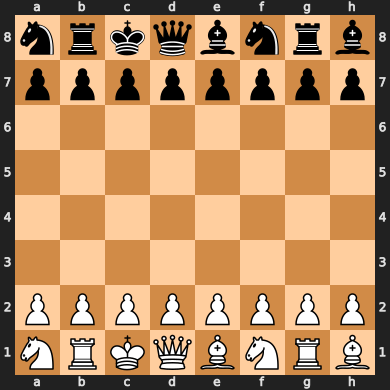

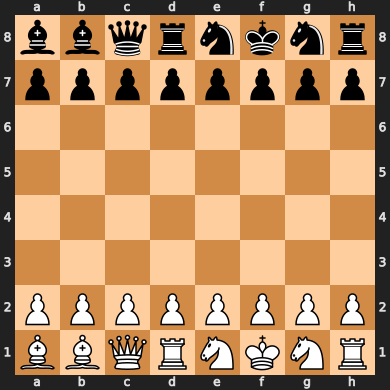

In [177]:
from IPython.display import SVG, display

def plot_board_positions(fens):
    for fen in fens:
        display(chess.Board(fen))

print("The worst positions are:")
plot_board_positions([worst_low_dist['fen'].values[0], worst_high_dist['fen'].values[0]])

The best positions are:


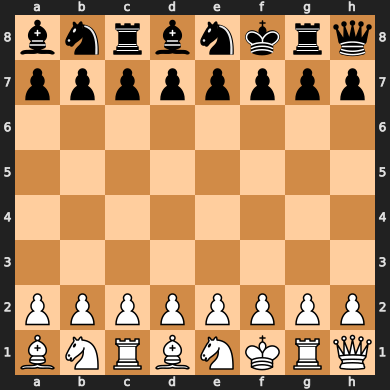

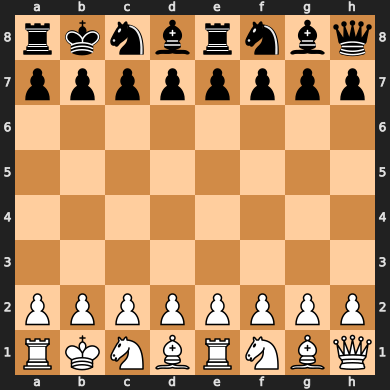

In [178]:
print("The best positions are:")
plot_board_positions([best_low_dist['fen'].values[0], best_high_dist['fen'].values[0]])

## We also plot the distributions over the ELO difference ranges

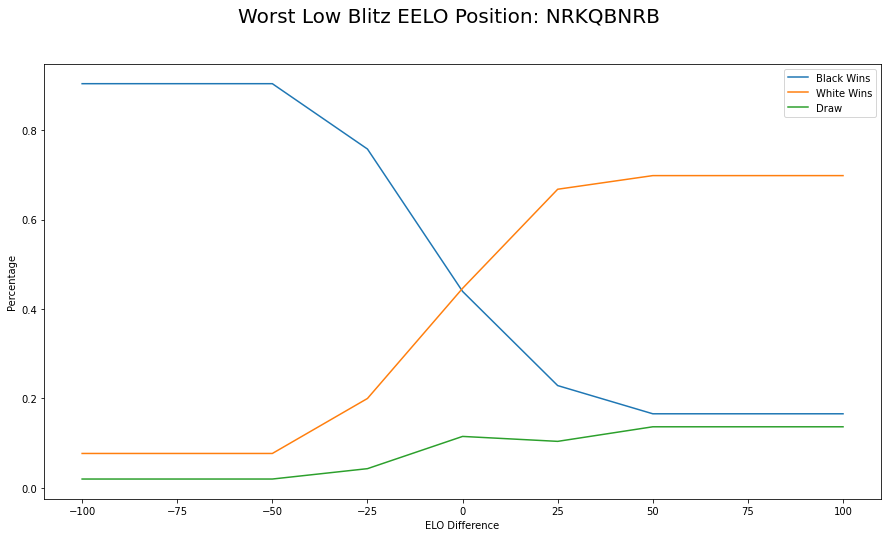

In [179]:
def plot_results(df, title):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=df, x='white_elo_diff', y='0-1', label='Black Wins')
    sns.lineplot(data=df, x='white_elo_diff', y='1-0', label='White Wins')
    sns.lineplot(data=df, x='white_elo_diff', y='1/2-1/2', label='Draw')
    plt.xlabel('ELO Difference')
    plt.ylabel('Percentage')
    fig = plt.gcf()
    fig.suptitle(title, size=20)
    plt.savefig(f"images/{title}.png")
    
plot_results(worst_low_dist, f"Worst Low Blitz EELO Position: {worst_low_dist['position'].values[0].upper()}")

In [180]:
plot_results(best_low_dist, f"Best Low Blitz ELO Position: {best_low_dist['position'].values[0].upper()}")

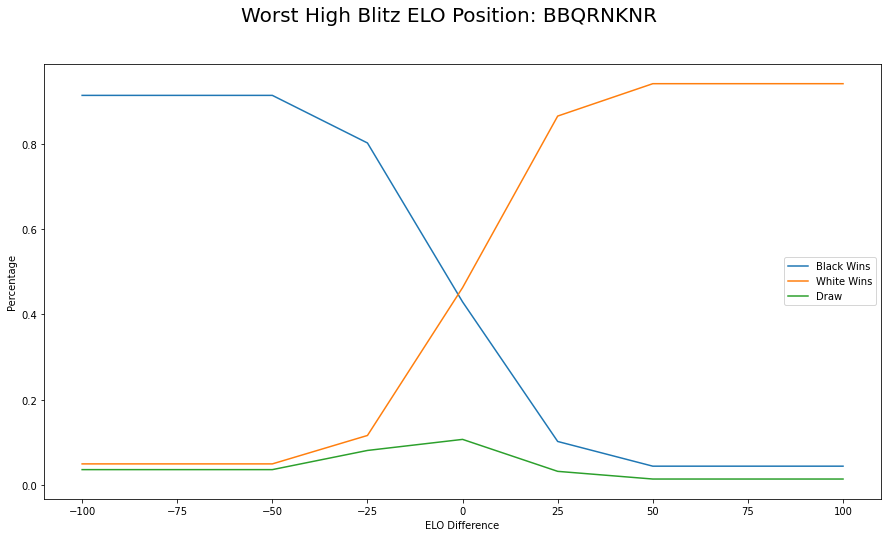

In [182]:
plot_results(worst_high_dist, f"Worst High Blitz ELO Position: {worst_high_dist['position'].values[0].upper()}")

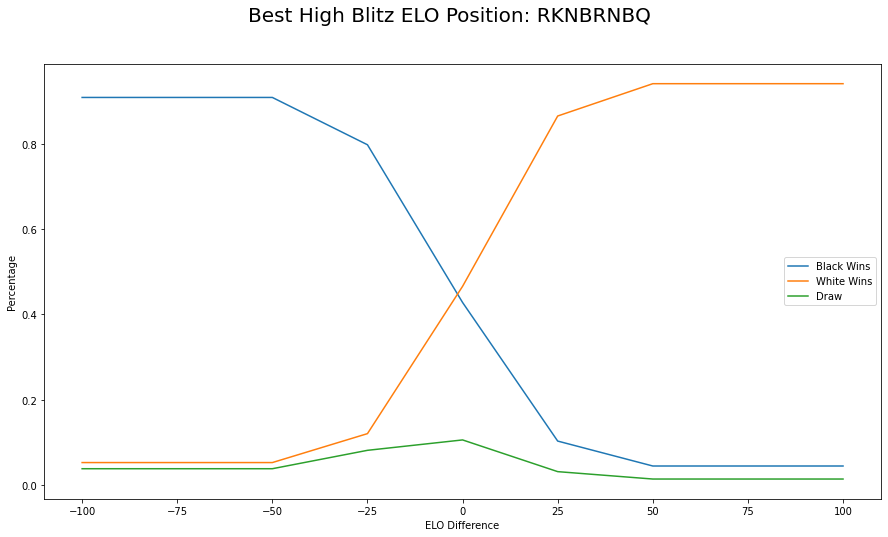

In [183]:
plot_results(best_high_dist, f"Best High Blitz ELO Position: {best_high_dist['position'].values[0].upper()}")

## Finally we can pickle our model for future use

In [184]:
import cloudpickle

output_data = {
    'preprocessing_func': preprocess_data,
    'scaler': scaler,
    'model': model
}

with open('fun_960_game_model.pkl', 'wb') as f:
    cloudpickle.dump(output_data, f)